# Training Logistic Regression via Stochastic Gradient Ascent

**Goal:** to implement a Logistic Regression classifier using a Stochastic Gradient Ascent algorithm.

In this notebook, we:
 * Extract features from Amazon product review data into a NumPy bidimensional array.
 * Write a helper function that computes the partial derivative (single coefficient) of the log-likelihood function.
 * Implement Stochastic Gradient Ascent.
 * Compare convergence of Stochastic Gradient ascent with Batch Gradient ascent.

In [1]:
import turicreate
import numpy as np

## Part 1. Prepare the Data

For this assignment, we use a subset that has a similar number of positive and negative reviews.

In [2]:
products = turicreate.SFrame('../data/amazon_baby_subset.sframe/')

In [3]:
import string 

# Define a function to remove punctuation from review text
def remove_punctuation(text):
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

As in a previous notebook, we work with a hand-curated list of important words extracted from the review data. 

In [4]:
import json

# Store the important words from json file into an array
with open('important_words.json', 'r') as f: 
    important_words = json.load(f)
    
important_words = [str(s) for s in important_words]

# Create a column with a punctuation-free version of the text
products['review_clean'] = products['review'].apply(remove_punctuation)

# Create word-count column for each of the important words
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

The SFrame **products** now contains one column for each of the 193 **important_words**. 

In [5]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


### Training and validation split

We will now split the data into a 90-10 split where 90% is in the training set and 10% is in the validation set. 

In [6]:
train_data, validation_data = products.random_split(.9, seed=1)


print(f'Training set  : {len(train_data)} data points' )
print(f'Validation set: {len(validation_data)} data points')

Training set  : 47780 data points
Validation set: 5292 data points


### Convert from SFrame to NumPy Matrix

In [7]:
"""
Receives an SFrame, a list of input feature names and the name of desired output (target).
Returns a Numpy matrix of the inputs and a Numpy array containing the output values.
"""
def get_numpy_data(data_sframe, features_list, target):
    # Add a column of ones for the constant parameter w0
    data_sframe['intercept'] = 1 
    features_list = ['intercept'] + features_list
    
    # Matrix containing feature values
    features_sframe = data_sframe[features_list]
    feature_matrix = features_sframe.to_numpy()
    
    # Numpy array of target label values
    output_sarray = data_sframe[target]
    output_array = output_sarray.to_numpy()
    
    return (feature_matrix, output_array)

In [8]:
# WAITING WARNING: a couple minutes
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

**Quiz Question**: In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features?

`A = Features stay the same`

# Part 2. Extending on Logistic Regression

### Link function

The Link Function used for Logistic Regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 


We can reuse some of the same code from the notebook from Week 3 to make probability prediction. 
The only difference from regular Gradient Ascent is at the moment of learning the coefficients.

In [9]:
'''
Produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
Returns an array of the N predicted probabilities.
'''
from math import e
def predict_probability(feature_matrix, coefficients):
    # Scores for every data point (N-size array)
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) via the link function  (N-size array)
    predictions = 1 / (1+e**(-score))
    
    # return Predicted Probabilities array
    return predictions

### Helper function: Partial of log likelihood with respect to a single coefficient

**The derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

We define a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. 
The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$

In [10]:
"""Computes the partial derivative with respect to the j-th coefficient
    Receives:
    *  an errors vector (difference between indicator and predicted probability)
    *  a features vector which contains the j-th feature's values over all obervations
    """
def feature_derivative(errors, feature):     
    # Compute the dot product of errors and feature vectors
    derivative = np.dot(errors, feature)
    
    # Return the derivative
    return derivative

**Note**. We are not using regularization in this assignment, though stochastic gradient can also be used for regularized logistic regression.

### Computing Average Log Likelihood

To track the performance of stochastic gradient ascent, we are provided a function for computing the **average log likelihood** from a fixed set of coefficients. This function can be used later to generate plots that are similar to those seen in the course lectures.

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** We've added a $\color{red}{1/N}$ term which averages the log likelihood accross all N data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. 

In [11]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment == +1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)    # returns an array of booleans indicating if the corresponding value is +/- infinity
    logexp[mask] = -scores[mask]   # replace infinite values with negative score
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

**Quiz Question:** Recall from the lecture and the earlier assignment, the log likelihood (without the averaging term) is given by 

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

How are the functions $\ell\ell(\mathbf{w})$ and $\ell\ell_A(\mathbf{w})$ related?
`A: ll_a is simply the ll function divided by N`

## Stochastic Ascent (single point gradient)

The gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


**Computing the gradient for a single data point**

We do not need a lot of modified code to go from $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$.

Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


As a demostration, we compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [12]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

# We first compute probability predictions for the i-th data point.
predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)

# We then compute the indicator function whether y_i is positive
indicator = (sentiment_train[i:i+1]==+1)

# Compute the difference between truth and prediction
errors = indicator - predictions  

# Our feature_derivative function takes in the error from predictions made.
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])


print("Gradient single data point: %s" % gradient_single_data_point)
print("           --> Should print 0.0")
if gradient_single_data_point == 0.0:
    print("Test Passed!")
else:
    print("Test failed!")

Gradient single data point: 0.0
           --> Should print 0.0
Test Passed!


**Quiz Question:** The code block above computed $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$ for `j = 1` and `i = 10`.  Is $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$ a scalar or a 194-dimensional vector? `A scalar`

## Batch Gradient

Given a mini-batch (or a subset of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$


**Demonstration: Computing the gradient for a "mini-batch" of data points**

We compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [13]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Batch size

coefficients = np.zeros(194) # A point w at which we are computing the gradient.

# Compute probability predictions for the batch
batch_features = feature_matrix_train[i:i+B,:]
predictions = predict_probability(batch_features, coefficients)

# Compute indicator function for the batch
batch_labels = sentiment_train[i:i+B]
indicator = (batch_labels == +1)

# Compute the error for our feature_derivative function
errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])

print("Gradient mini-batch data points: %s" % gradient_mini_batch)
print("                --> Should print 1.0")
if gradient_mini_batch == 1.0:
    print("Test Passed!")
else:
    print("Test failed!")

Gradient mini-batch data points: 1.0
                --> Should print 1.0
Test Passed!


**Quiz Question:** The code block above computed 
$\color{red}{\sum_{s = i}^{i+B}}\partial\ell_{s}(\mathbf{w})/{\partial w_j}$ 
for `j = 10`, `i = 10`, and `B = 10`. Is this a scalar or a 194-dimensional vector? `A = scalar`


**Quiz Question:** For what value of `B` is the term
$\color{red}{\sum_{s = 1}^{B}}\partial\ell_{s}(\mathbf{w})/\partial w_j$
the same as the full gradient
$\partial\ell(\mathbf{w})/{\partial w_j}$? Hint: consider the training set we are using now.
`A = 47780 `

### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$

In this approach, we update the coefficients using the **average gradient over data points** (instead of summing across the batch). 

By using the average gradient, we ensure that the magnitude of the gradient is roughly the same for all possible batch sizes of a dataset. This way, we can more easily compare various batch sizes of stochastic gradient ascent and study the effect of batch size and the choice of step size.

# Part 3. Implementing Stochastic Gradient Ascent

In [14]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    coefficients = np.array(initial_coefficients)
    
    np.random.seed(seed=1) # To produce consistent results
    
    # Shuffle the data
    permutation = np.random.permutation(len(feature_matrix))  # obtain a random permutation
    feature_matrix = feature_matrix[permutation,:]  # re-order the rows of feature matrix
    sentiment = sentiment[permutation]  # re-order the entries of sentiment array
    
    i = 0 # index for current batch starting row
    
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) probabilities for the batch
        batch_rows = feature_matrix[i:i+batch_size,:]
        predictions = predict_probability(batch_rows, coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        batch_labels = sentiment[i:i+batch_size]
        indicator = (batch_labels == +1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        
        # loop over each coefficient
        for j in range(len(coefficients)): 
            # Grab the feature values of current batch and compute the gradient from the batch
            features_j = feature_matrix[i:i+batch_size,j]
            derivative = feature_derivative(errors, features_j)
            
            # Update the j-th coefficient by the average gradient of the batch times step-size
            coefficients[j] += step_size * (1.0/batch_size) * derivative 
        
        
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        
        # Print after a certain number of iterations to check log likelihood increasing
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))
        
        
        # if we made a complete pass over data, reshuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            # Reshuffle
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            # Restart index
            i = 0
                
    # Return the list of log-likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

**Note**. In practice we rarely use the last set of coefficients returned by the SG Algorithm.
We usually use the average of the last K returned coefficients, where K is adjusted depending on how fast the log likelihood oscillates around the optimum.

### Checkpoint


The following cell tests your stochastic gradient ascent function using a toy dataset consisting of two data points. If the test does not pass, make sure you are normalizing the gradient update rule correctly.

In [15]:
## -- TEST OUR SG ALGORITHM --
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print('-------------------------------------------------------------------------------------')
print('Coefficients learned                 :', coefficients)
print('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3) and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341]), atol=1e-3):
    print('-------------------------------------------------------------------------------------')
    print('Test passed!')
else:
    print('-------------------------------------------------------------------------------------')
    print('Test failed')

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


# Part 4. Comparing Convergence of Stochastic Gradient and Batch Gradient

For the remainder of this notebook, we will compare the convergence of Batch Gradient Ascent (where `batch_size` is N) and Stochastic Gradient (`batch_size` of 1).

*Note*: our implementation here would be slightly different than the Gradient Ascent from the earlier notebooks, since we are now normalizing the gradient update rule.


To visualize the effect on our objective to maximize (log likelihood), we run **Stochastic Gradient** ascent over the `feature_matrix_train` for 10 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [16]:
# DEMOSTRATION Stochastic Gradient Ascent: batch size of 1
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


**Quiz Question**. When you set `batch_size = 1`, as each iteration passes, how does the average log likelihood in the batch change?
* Fluctuates 

### Running Normal Gradient Ascent (Batch size = N)
Next we run a normal **Gradient ascent** of batch size = N over the same dataset and these parameters, and store the set of computed likelihood values in `log_likelihood_batch`. This variable will later be used for the plot.

In [17]:
initial_coefficients=np.zeros(194)
step_size = 5e-1
batch_size = len(feature_matrix_train)
max_iter = 200

coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients,
                                        step_size, batch_size, max_iter)

Iteration   0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points in batch [00000:47780]) = 

**Quiz Question**. When you set `batch_size = len(feature_matrix_train)`, the average log likelihood **increases** after each iteration

### Number of "passes" over the dataset

To make a fair comparison betweeen Stochastic and Batch Gradient ascent, we should measure the average log likelihood as a function of the number of passes, defined as:
$$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

The number of iterations of our algorithm should be equal to the number of passes times the number of batches that fit in the dataset.

**Quiz Question** Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?
`A = 2*(50000/100) = 1,000`

### Log-likelihood plot of Stochastic gradient ascent 

With the terminology in mind, let us run stochastic gradient ascent for 10 passes, since our batch algorithm was run for 10 iterations.

In [18]:
step_size = 1e-1
batch_size = 100
num_passes = 10
initial_coefficients = np.zeros(194)

# From the numer of passes desired we can compute necessary iterations
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

# Average ll is an average from the given batch of the iteration
coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients,
                                       step_size, batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

#### Utility function to plot the average log likelihood as a function of the # of Passes over the data.

In [25]:
# NOTE: This code was provided and is not of my authorship

import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

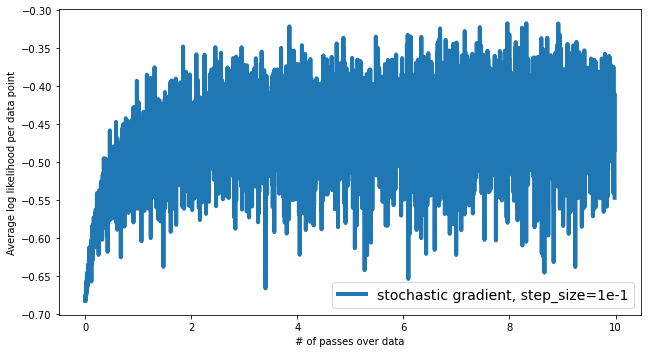

In [20]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

#### Smoothing out the curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. 

In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

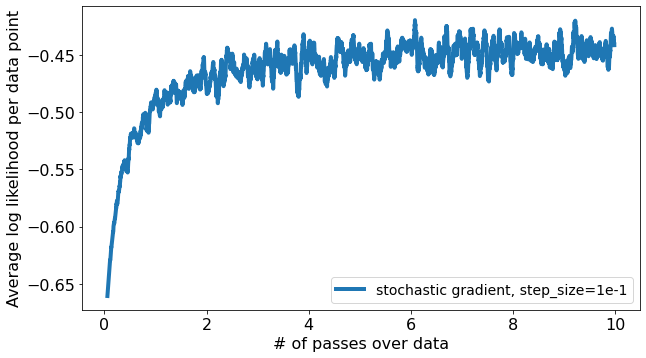

In [21]:
# Instead of plotting avg likelihood of a current batch, plot the average of the past 30 batches

make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

**Checkpoint**: The above plot should look smoother than the previous plot. Play around with `smoothing_window`. As you increase it, you should see a smoother plot.

## Stochastic Gradient vs Batch gradient ascent

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **"batch" gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

We run stochastic gradient ascent for 200 passes:

In [22]:
# WAITING WARNING

step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)
initial_coefficients = np.zeros(194)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients,
                                       step_size, batch_size, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points in b

We compare the convergence of stochastic gradient ascent and batch gradient ascent in the following cell. Note that we apply smoothing with `smoothing_window=30`.

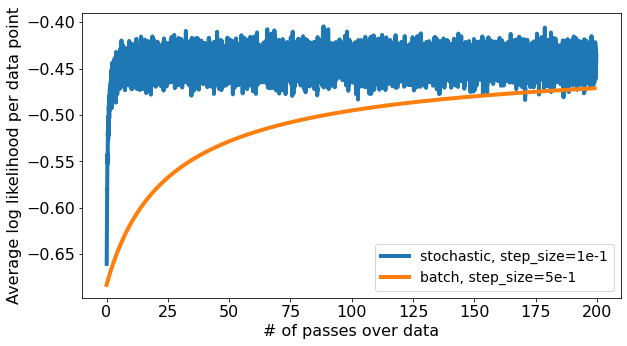

In [23]:
# Batch size of 100
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')

# Batch size of N
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

**Quiz Question**: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent? 

1. It's always better
2. 10 passes
3. 20 passes
4. 150 passes or more `CORRECT`

# Part 5. Exploring the effects of step size on Stochastic Gradient ascent

Step Size is an important tuning parameter in Stochastic Gradient ascent.

We explore a wide range of step sizes that are equally spaced in the log space. 

We run stochastic gradient ascent with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2.
We also set `max_iter` initialized so as to run 10 passes over the data.

In [26]:
initial_coefficients = np.zeros(194)
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train) / batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, 
                                                                                        sentiment_train,
                                                                                        initial_coefficients,
                                                                                        step_size, batch_size, 
                                                                                        max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -0.56306510
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900

Iteration 4000: Average log likelihood (of data points in batch [18400:18500]) = -2.47834692
Iteration 4769: Average log likelihood (of data points in batch [47600:47700]) = -2.48776279
Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -2.44471310
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -36.66862050
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -25.49870239
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -40.14565040
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -27.03748522
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -32.62294582
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -25.88017915
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -37.30720216
Iteration    8: Average log likelihood (of data points in batch

<ipython-input-11-542955b35fb2>:5: RuntimeWarning: overflow encountered in exp
  logexp = np.log(1. + np.exp(-scores))


Iteration  100: Average log likelihood (of data points in batch [10000:10100]) = -10.64501704
Iteration  200: Average log likelihood (of data points in batch [20000:20100]) = -4.03845822


<ipython-input-9-a54d7055e457>:12: RuntimeWarning: overflow encountered in power
  predictions = 1 / (1+e**(-score))


Iteration  300: Average log likelihood (of data points in batch [30000:30100]) = -3.06596125
Iteration  400: Average log likelihood (of data points in batch [40000:40100]) = -2.87237269
Iteration  500: Average log likelihood (of data points in batch [02300:02400]) = -7.96080945
Iteration  600: Average log likelihood (of data points in batch [12300:12400]) = -11.68050122
Iteration  700: Average log likelihood (of data points in batch [22300:22400]) = -11.62734854
Iteration  800: Average log likelihood (of data points in batch [32300:32400]) = -6.14081900
Iteration  900: Average log likelihood (of data points in batch [42300:42400]) = -7.08104639
Iteration 1000: Average log likelihood (of data points in batch [04600:04700]) = -5.90965960
Iteration 2000: Average log likelihood (of data points in batch [09200:09300]) = -11.76166719
Iteration 3000: Average log likelihood (of data points in batch [13800:13900]) = -2.08245439
Iteration 4000: Average log likelihood (of data points in batch [18

### Plot of log likelihood curves for each step size as a function of passes over the data

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

For consistency, we again apply `smoothing_window=30`.

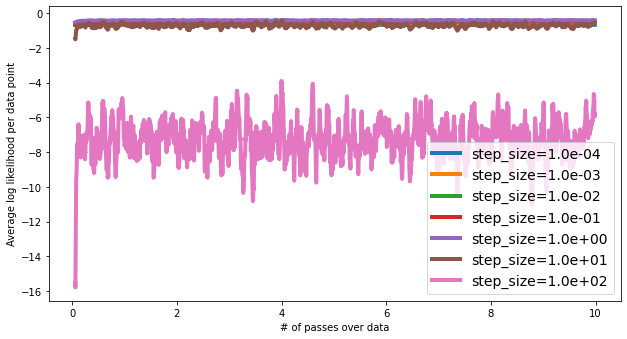

In [27]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Looks like the curve for step size 1e2 does not let us visualize the other plots in detail.

Let's remove the step size `step_size = 1e2` and plot the rest of the curves.

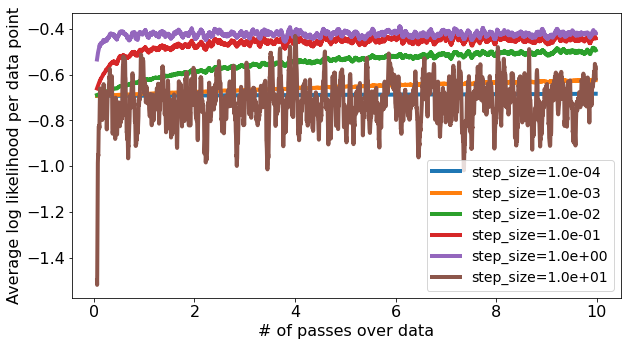

In [28]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

**Quiz Question**: Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.
1. 1e-2
2. 1e-1
3. 1e0
4. 1e1
5. 1e2 `WORST STEP SIZE`

**Quiz Question**: Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.
1. 1e-4
2. 1e-2
3. 1e0 `BEST STEP SIZE`
4. 1e1
5. 1e2